<a href="https://colab.research.google.com/github/hli8nova/blog_code-Zak-Jost-tab2graph/blob/master/tab2graph_fraud/xente_tabular_to_graph_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note: Change runtime type to include GPU**

## What this covers
This is about gaining an intuition for converting tabular-structured data into graph-structured data.  We will work through a Fraud Detection example using an open source dataset.  The focus will be on the data preparation, and *not* on the modeling.  Some models will be built for reference, but this process will not be described in depth.  

If you want to learn more about modeling on graphs, I have a free course: [Basics of Graph Neural Networks](https://www.graphneuralnets.com/p/basics-of-gnns/).  There are also paid courses that go deeper (e.g., [Introduction to Graph Neural Networks](https://www.graphneuralnets.com/p/introduction-to-gnns)), but the free course is a good way to get a quick overview of the basics.  

## How convert relational databases to graph-structured data?
As a general approach, review Neo4j's [guide](https://neo4j.com/developer/relational-to-graph-modeling/) on converting relational databases to graph-structured data.  A condensed summary:
- Rows -> nodes
- Join keys -> edges 
- Columns (excluding Join keys) -> node properties

![](https://github.com/hli8nova/blog_code-Zak-Jost-tab2graph/blob/master/tab2graph_fraud/neo4j_relational_graph_model.jpg?raw=1)

*Image credit to Neo4j article:  https://neo4j.com/developer/relational-to-graph-modeling/*

## How convert tabular datasets to graph-structured data?
The above describes a process when you have a database with multiple tables.  What about when you just have a single tabular dataset?  The first point to make is that *it may not be a good idea to represent the data as a graph*.  You can try it, and you might come up with a useful representation, but there's no gaurantees that graph-based methods will be useful.  The key question is:  **are there relationships between my datapoints that will help me solve the task?**  It's not always clear in advance, and some exploratory data analysis can be helpful.

Caveats out of the way, this is my general approach to identifying nodes and edges:
- Entities with many unique values (i.e., high-cardinality categorical variables) are nodes
  - E.g., user, credit card number, transaction ID, movie, 
- Covariates that describe the entities are properties of the node
  - E.g., age of the user, country for credit card, title/genre of movie
- Edges are the verbs/actions that relate the entities
  - E.g., "user-rates-movie", "user-buys-product", "movie-directed_by-person"
- Covariates that describe the actions/relationships are properties of the edge
  - E.g., the rating a user gives to the movie; purchase amount/count;
  
  
There can be some ambiguity in whether a column should be a node or a node property.  For example, the country of a user could be a property of the User node, or might be its own node that relates users via a "user-lives_in-country" relation.  **There is no single answer**, and it will likely require experimentation to find an optimal representation for the task at hand.

## Example
The [Xente Fraud Detection Challenge](https://zindi.africa/competitions/xente-fraud-detection-challenge/submissions) from Zindi.  To get started,
- go to the link
- create an account
- download the data
- upload it to the colab notebook environment


In [1]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Install DGL for working with the graph

In [2]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 1.12.1+cu113.  CUDA version: 11.3


In [3]:
# dgl_version = f"dgl-cu{th.version.cuda.replace('.', '')}==0.7.2"
dgl_version = f"dgl-cu{th.version.cuda.replace('.', '')}"
dgl_version

'dgl-cu113'

In [4]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install {dgl_version} -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 239.2 MB 1.1 kB/s 
     |████████████████████████████████| 280 kB 1.4 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [5]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn

In [6]:
dgl.__version__

'0.9.1post1'

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# from dgl.dataloading.pytorch import nodeDataLoader
from dgl.dataloading import DataLoader

In [9]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the data
Upload the data to the machine before proceeding to next steps

In [10]:
# !tar xzf data.tar.gz


In [11]:
!pwd

/content


In [12]:
!ls

gdrive	sample_data


In [13]:
# !cat Xente_Variable_Definitions.csv

In [14]:
!mkdir -p models

### EDA

In [15]:
df_train = pd.read_csv('gdrive/MyDrive/zindi_dataset/training.csv')
df_train['dataset'] = 'train'
df_test = pd.read_csv('gdrive/MyDrive/zindi_dataset/test.csv')
df_test['dataset'] = 'test'

In [16]:
df = pd.concat([df_train, df_test], axis=0)

In [17]:
df.shape

(140681, 17)

In [18]:
df['dataset'].value_counts()

train    95662
test     45019
Name: dataset, dtype: int64

In [19]:
df.groupby('dataset').nunique().T

dataset,test,train
TransactionId,45019,95662
BatchId,44684,94809
AccountId,2471,3633
SubscriptionId,2470,3627
CustomerId,5018,3742
CurrencyCode,1,1
CountryCode,1,1
ProviderId,6,6
ProductId,26,23
ProductCategory,9,9


### Conclusions:
- `TransactionId` is unique, and the level at which predictions should be made.  We will create Transaction nodes and make this a node classification problem.
- `BatchId` is very high cardinality (almost unique) and will be ignored.  
  - A future improvement might be investigating whether `BatchId` connects transactions in a narrow time window, and might provide another edge type for relating transactions.
- `AccountId`, `SubscriptionId`, `CustomerId` have thousands of unique, which means they connect many of the transactions and are good candidates for nodes.
- Attributes with a handful of unique are candidates for (categorical) features of transaction nodes (e.g., `ProviderId`, `ProductId`, `ProductCategory`, `ChannelId`, `PricingStrategy`).  Using these as nodes would likely not be optimal since they would connect large portions of the graph.  
- The sign on `Amount` can be used to indicate credit/debit, and `Value` can be a numerical feature (scaled with log transformation).

In [20]:
df.nunique()

TransactionId           140681
BatchId                 139493
AccountId                 4841
SubscriptionId            4836
CustomerId                7479
CurrencyCode                 1
CountryCode                  1
ProviderId                   6
ProductId                   27
ProductCategory             10
ChannelId                    5
Amount                    2099
Value                     1880
TransactionStartTime    138574
PricingStrategy              4
FraudResult                  2
dataset                      2
dtype: int64

Note that since the unique number of Account/Subscription/Customer is higher in the train+test case than just the training set, this implies there will be nodes of this type present in the test set that were not observed in the training set.  We will need a strategy for generating features for these nodes.

In [21]:
df.groupby('dataset')['FraudResult'].mean()

dataset
test          NaN
train    0.002018
Name: FraudResult, dtype: float64

In [22]:
df.groupby('AccountId')['CustomerId'].nunique().describe()

count    4841.000000
mean        2.784136
std        65.823379
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3334.000000
Name: CustomerId, dtype: float64

In [23]:
df.groupby('CustomerId')['AccountId'].nunique().describe()

count    7479.000000
mean        1.802113
std         0.913124
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         6.000000
Name: AccountId, dtype: float64

In [24]:
df.groupby('AccountId')['SubscriptionId'].nunique().describe()

count    4841.000000
mean        1.000413
std         0.020324
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: SubscriptionId, dtype: float64

### Construct a graph

In [25]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,dataset
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0.0,train
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0.0,train
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0.0,train
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0.0,train
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0.0,train


In [26]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [27]:
txn2idx = {v: idx for idx, v in enumerate(df['TransactionId'].values)}
acct2idx = column_index(df['AccountId'])
sub2idx = column_index(df['SubscriptionId'])
cust2idx = column_index(df['CustomerId'])

In [28]:
df['txnIdx'] = df['TransactionId'].map(txn2idx)
df = df.sort_values(by='txnIdx')
df['acctIdx'] = df['AccountId'].map(acct2idx)
df['subIdx'] = df['SubscriptionId'].map(sub2idx)
df['custIdx'] = df['CustomerId'].map(cust2idx)

In [29]:
y_txn = df.sort_values(by='txnIdx')['FraudResult'].values
y_txn

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [30]:
baseline = y_txn[y_txn>=0].mean()
baseline

0.00201752001839811

In [31]:
# node_id_cols = ['txnIdx', 'acctIdx', 'subIdx', 'custIdx']
node_id_cols = ['txnIdx', 'subIdx', 'acctIdx']

In [32]:
df[node_id_cols].head()

,txnIdx,subIdx,acctIdx
0,0,207,209
1,1,0,0
2,2,3658,3660
3,3,551,536
4,4,0,0


In [33]:
N_nodes = df[node_id_cols].nunique().sum()
N_nodes

150358

In [34]:
N_labels = df[df['dataset']=='train'].shape[0]

### Construct edges 
Need the indices of pairs of nodes.  Here, we will use all combinations of node types since we don't know much about the graph and analysis shows that there are many-to-many relationships between accounts, subscriptions and customers.

In [35]:
from itertools import combinations

In [36]:
edge_dict = dict()
for src_type, dst_type in combinations(node_id_cols, 2):
    fwd = (src_type, f'{src_type}-{dst_type}', dst_type)
    bwd = (dst_type, f'{dst_type}-{src_type}', src_type)
    print(fwd)
    print(bwd)
    print('-'*50)
    
    edges = df[[src_type, dst_type]].drop_duplicates().values
    src = edges[:,0]
    dst = edges[:,1]

    edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
    edge_dict[bwd] = (th.tensor(dst), th.tensor(src))

('txnIdx', 'txnIdx-subIdx', 'subIdx')
('subIdx', 'subIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-subIdx', 'subIdx')
--------------------------------------------------


In [37]:
hg = dgl.heterograph(edge_dict)

In [38]:
hg.ntypes

['acctIdx', 'subIdx', 'txnIdx']

In [39]:
label_feat = dict()
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        continue
    label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype))+baseline
label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()

In [40]:
hg.ndata['label'] = label_feat

In [41]:
hg

Graph(num_nodes={'acctIdx': 4841, 'subIdx': 4836, 'txnIdx': 140681},
      num_edges={('acctIdx', 'acctIdx-subIdx', 'subIdx'): 4843, ('acctIdx', 'acctIdx-txnIdx', 'txnIdx'): 140681, ('subIdx', 'subIdx-acctIdx', 'acctIdx'): 4843, ('subIdx', 'subIdx-txnIdx', 'txnIdx'): 140681, ('txnIdx', 'txnIdx-acctIdx', 'acctIdx'): 140681, ('txnIdx', 'txnIdx-subIdx', 'subIdx'): 140681},
      metagraph=[('acctIdx', 'subIdx', 'acctIdx-subIdx'), ('acctIdx', 'txnIdx', 'acctIdx-txnIdx'), ('subIdx', 'acctIdx', 'subIdx-acctIdx'), ('subIdx', 'txnIdx', 'subIdx-txnIdx'), ('txnIdx', 'acctIdx', 'txnIdx-acctIdx'), ('txnIdx', 'subIdx', 'txnIdx-subIdx')])

In [42]:
hg.ndata

defaultdict(<class 'dict'>, {'label': {'acctIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]), 'subIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]), 'txnIdx': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0020, 0.0020])}})

In [43]:
assert hg.number_of_nodes('txnIdx')==y_txn.shape[0]
assert (df['FraudResult']==1).sum() == (dgl.to_homogeneous(hg, ndata=['label']).ndata['label']==1).sum().item()

### Some exploration

In [44]:
import networkx as nx

In [45]:
def draw_kkl_hg(hg, **kwargs):
    
    hg_label = hg.ndata['label']['txnIdx'].int()
    
    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))
    
    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))
    
    nodeShapes = ["^", "s", "o", "v"]
    # For each node class...
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='txnIdx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]["ntype"]==idx, nx_G.nodes(data=True))]
        )

    # Draw the edges between the nodes
    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)     
        

def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }
    
    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
#                     print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }
        
        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')
        
        n_2hop = hg.ndata['d_sum']['txnIdx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, fraud_rate_2hop

## Visualization 
- Circles = transactions
  - blue=legit, red=fraud, black=unlabeled
- Triangle-Up = accounts
- Square = subscriptions

### Random sample

In [46]:
n_hops = 2
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)

In [47]:
# dataloader_legit = NodeDataLoader(
dataloader_legit = DataLoader(
    hg, {'txnIdx': np.where(y_txn==0)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/dgl/dataloading/dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


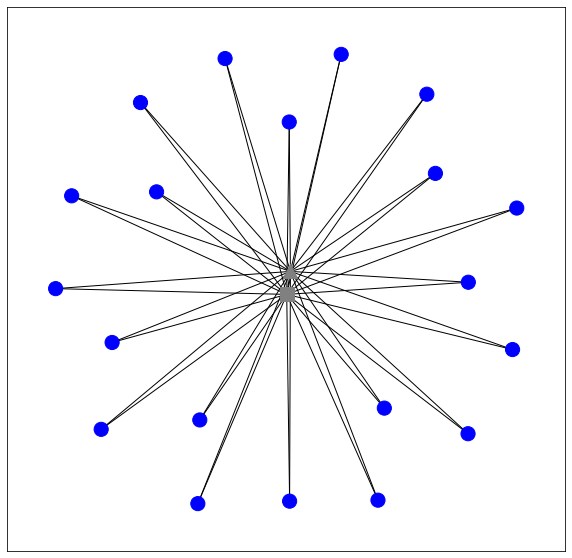

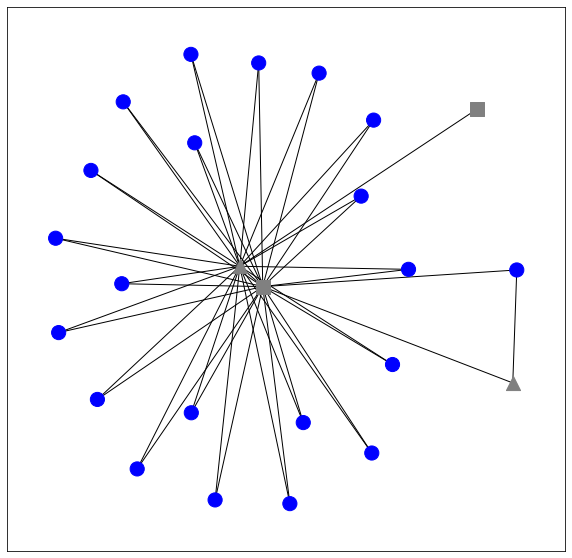

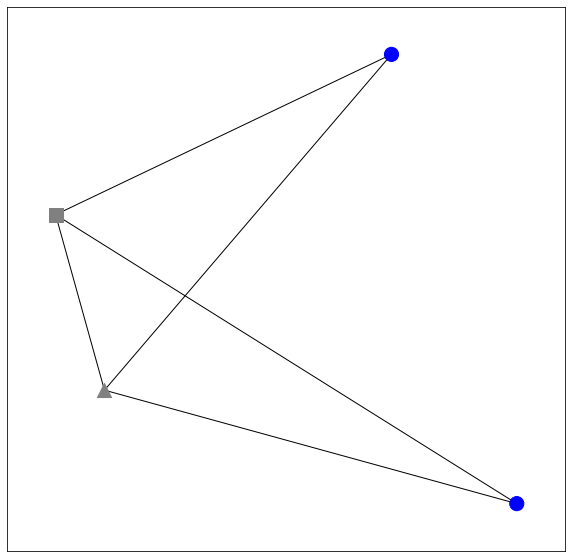

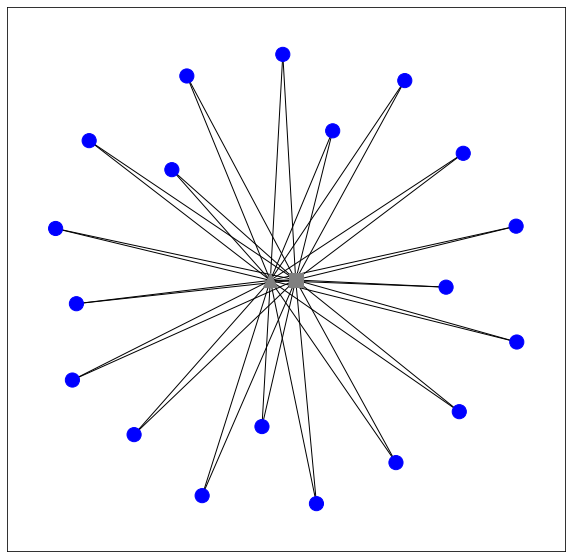

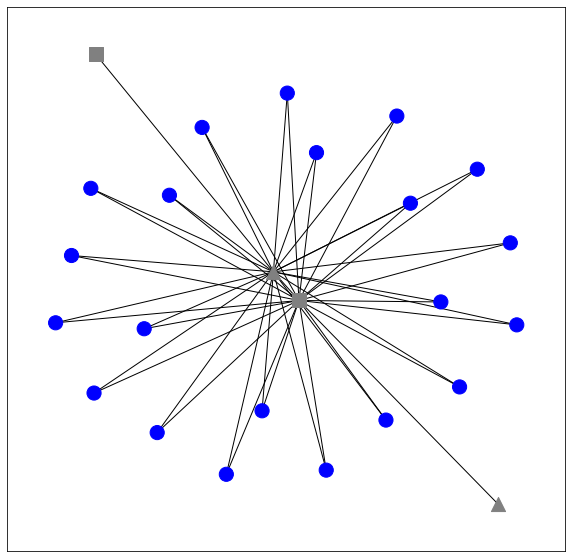

In [48]:
plot_neighborhood(dataloader_legit, N_plots=5)

### Known fraud

In [49]:
# dataloader_fraud = NodeDataLoader(
dataloader_fraud = DataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

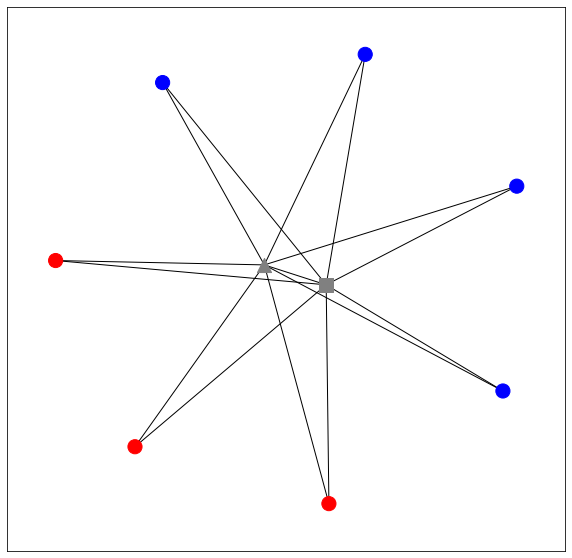

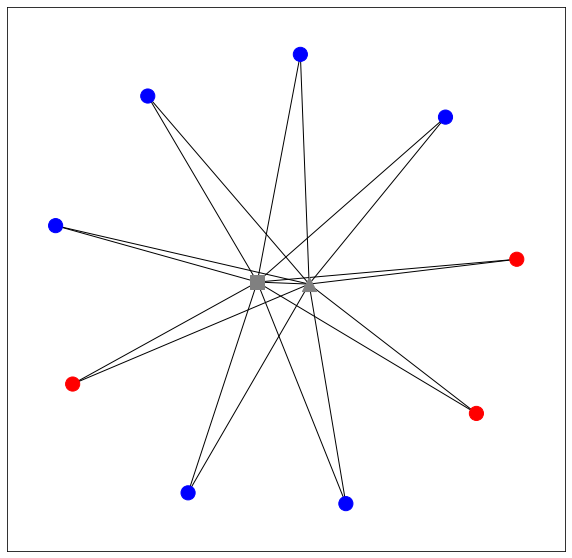

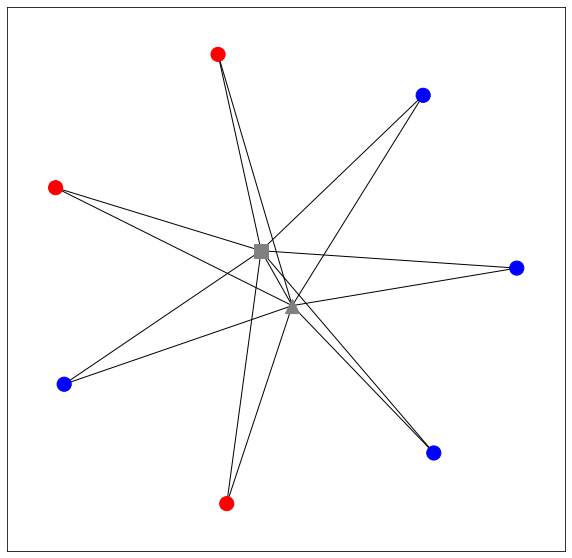

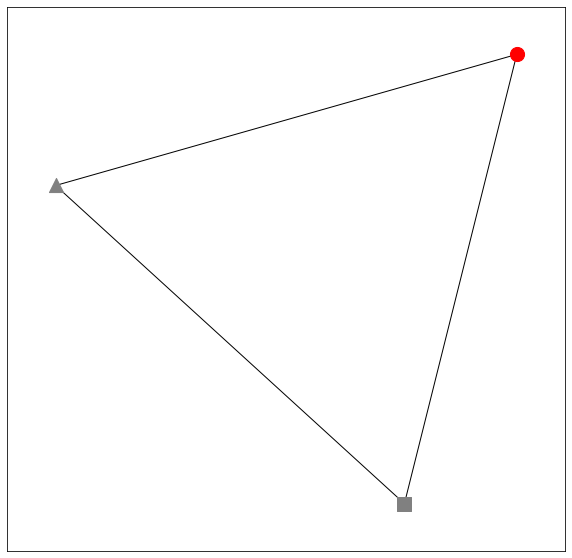

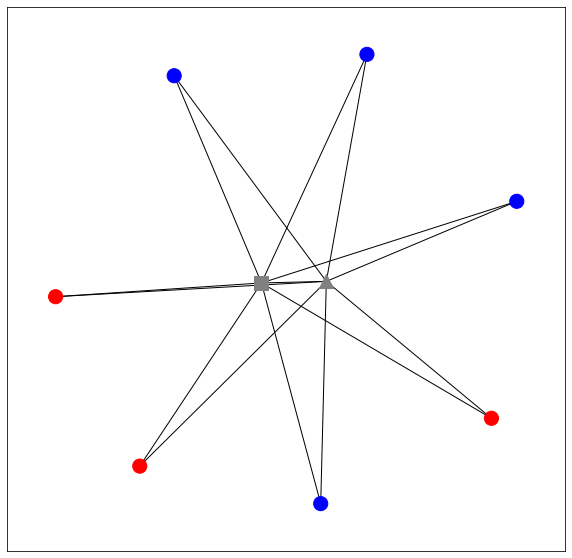

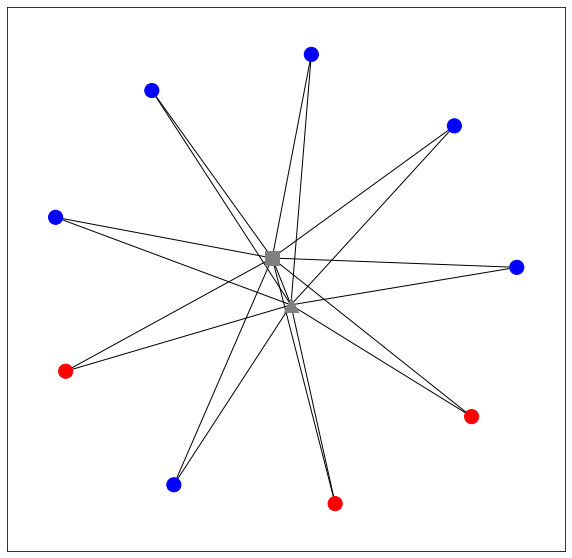

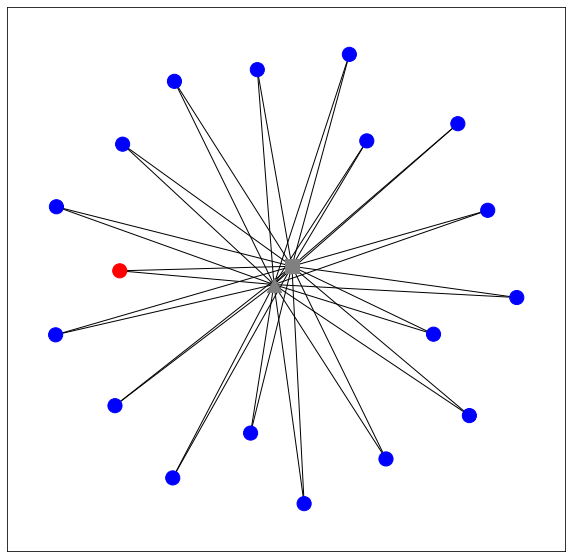

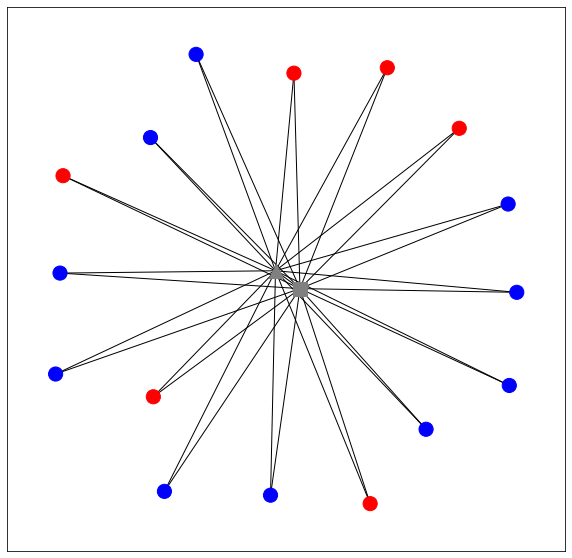

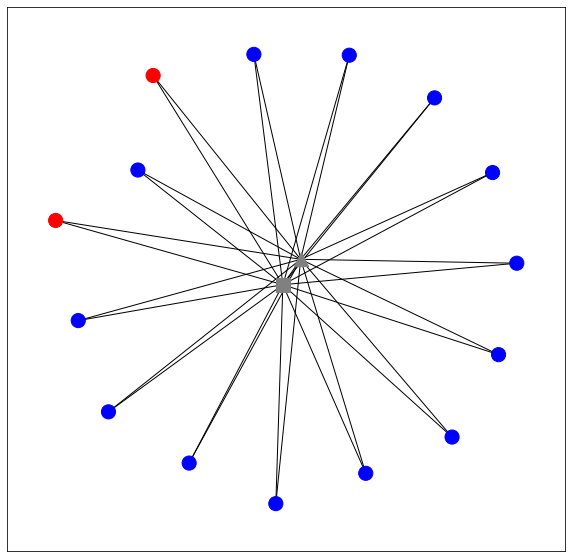

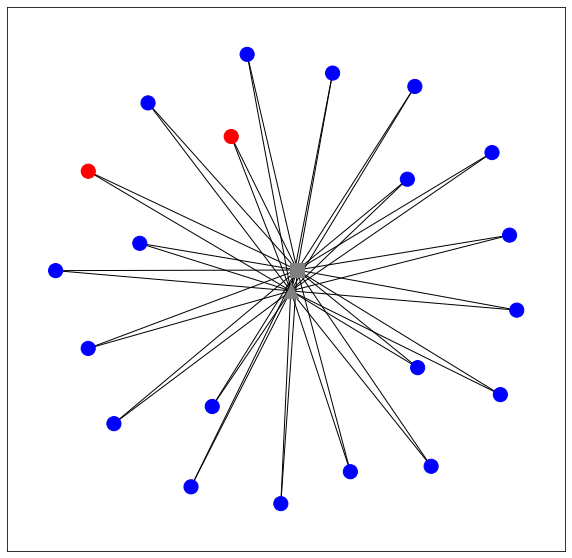

In [50]:
plot_neighborhood(dataloader_fraud, N_plots=10)

Collect stats for 2-hop neighborhood size and fraud rate

In [51]:
n_2hop, fraud_rate_2hop = neighborhood_stats(hg)

In [52]:
df_nstats = pd.DataFrame({
    'N_2hop': n_2hop[:N_labels], 
    'fraud_rate_2hop': fraud_rate_2hop[:N_labels], 
    'label': y_txn[:N_labels],
})

In [53]:
df_nstats.groupby('label').describe().T

label                           0.0           1.0
N_2hop          count  95469.000000    193.000000
                mean   30786.095703    812.088074
                std    41702.855469   6594.795410
                min        4.000000      4.000000
                25%       98.000000     32.000000
                50%      520.000000    102.000000
                75%    90171.000000    226.000000
                max    90171.000000  90171.000000
fraud_rate_2hop count  95469.000000    193.000000
                mean       0.001210      0.269275
                std        0.014854      0.221216
                min        0.000000      0.000022
                25%        0.000000      0.104167
                50%        0.000000      0.235294
                75%        0.000022      0.375000
                max        0.750000      0.750000

The fraud rate in the 2-hop neighborhood is far different.

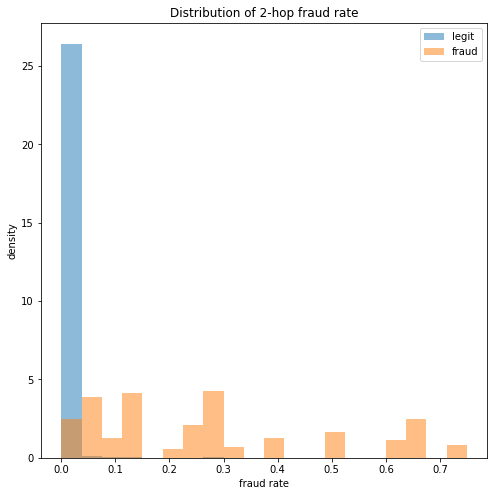

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(df_nstats[df_nstats['label']==0]['fraud_rate_2hop'], bins=20, alpha=0.5, density=True, label='legit')
_ = ax.hist(df_nstats[df_nstats['label']==1]['fraud_rate_2hop'], bins=bins, alpha=0.5, density=True, label='fraud')
ax.set(xlabel='fraud rate', ylabel='density', 
       title=f'Distribution of {n_hops}-hop fraud rate')
_ = ax.legend()

The average neighborhood size is much larger for legit, which is dominated by a heavy tail.

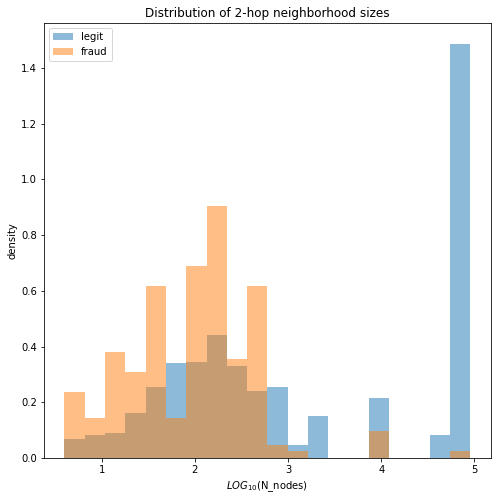

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==0]['N_2hop']), bins=20, alpha=0.5, density=True, label='legit'
)
_ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==1]['N_2hop']), bins=bins, alpha=0.5, density=True, label='fraud'
)
ax.set(xlabel='$LOG_{10}($N_nodes$)$', ylabel='density', 
       title=f'Distribution of {n_hops}-hop neighborhood sizes')
_ = ax.legend()

## Node features

In [56]:
df.nunique().sort_values(ascending=False)

TransactionId           140681
txnIdx                  140681
BatchId                 139493
TransactionStartTime    138574
custIdx                   7479
CustomerId                7479
AccountId                 4841
acctIdx                   4841
SubscriptionId            4836
subIdx                    4836
Amount                    2099
Value                     1880
ProductId                   27
ProductCategory             10
ProviderId                   6
ChannelId                    5
PricingStrategy              4
FraudResult                  2
dataset                      2
CurrencyCode                 1
CountryCode                  1
dtype: int64

In [57]:
categorical = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']

In [58]:
X_ohe = pd.get_dummies(df[categorical].astype(str), drop_first=True).values
X_amt = ((df['Amount']>0)*1).values
X_value = df['Value'].apply(np.log10).values

In [59]:
X_num = np.concatenate([X_amt.reshape((-1,1)), X_value.reshape((-1,1))], axis=1)
X_num = (X_num - X_num.mean(axis=0))/(X_num.max(axis=0) - X_num.min(axis=0))

In [60]:
X = np.concatenate([X_ohe, X_num], axis=1)

In [61]:
X.shape

(140681, 49)

In [62]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.00782616],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733, -0.26164142],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.05279812],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.40121267,  0.14156744],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733,  0.09659549],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.40121267,  0.07345412]])

## Modeling

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score

In [64]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
def plot_pr(y_trues, y_preds, labels):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        auc = roc_auc_score(y_true, y_pred)
        pr, re, thresholds = precision_recall_curve(y_true, y_pred)
        ax.plot(re, pr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)
        
        f1_scores = 2*re*pr/(re+pr)
        print(labels[i])
        print('Best threshold: ', thresholds[np.argmax(f1_scores)])
        print('Best F1-Score: ', np.max(f1_scores))

    ax.legend()
    ax.grid()
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')

In [65]:
baseline

0.00201752001839811

In [66]:
# Indicies w/ labels (training data)
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1
assert y_txn[labeled_mask].mean()==baseline

In [67]:
# Split of training data into train/validation sets
rng = np.random.default_rng(1)
train_rate = 0.7
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask

In [68]:
test_mask = ~labeled_mask

In [69]:
# Fraud rate in train/val
y_txn[train_mask].mean(), y_txn[val_mask].mean()

(0.0019413706076490001, 0.002195198438969999)

In [70]:
# Fraud count in train/val
y_txn[train_mask].sum(), y_txn[val_mask].sum()

(130.0, 63.0)

### Logistic Regression / RF

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [72]:
clf = LogisticRegression()
clf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lr = clf.predict_proba(X[val_mask,:])
y_val_lr = clf.predict(X[val_mask,:])

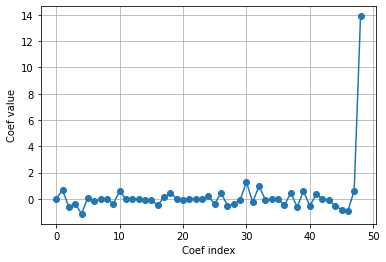

In [73]:
fig, ax = plt.subplots()
ax.plot(clf.coef_[0,:], '-o')
ax.set(xlabel='Coef index', ylabel='Coef value')
_ = ax.grid()

In [74]:
corrs = list()
for col in range(X.shape[1]):
    corr = np.corrcoef(X[train_mask,col], y_txn[train_mask])[0,1]
    corrs.append(corr)
corrs = np.array(corrs)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


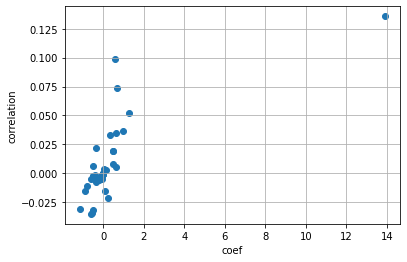

In [75]:
fig, ax = plt.subplots()
ax.scatter(x=clf.coef_[0,:], y=corrs)
ax.set(xlabel='coef', ylabel='correlation')
_ = ax.grid()

In [76]:
np.flip(np.argsort(np.nan_to_num(corrs, nan=-2)))

array([48, 10,  1, 30, 32, 47, 41,  3, 26, 37, 18, 44, 39,  8, 17, 19,  7,
       34, 11,  0, 23, 28, 33, 20, 29, 16, 36, 15,  9, 14, 43, 38,  6, 31,
       25, 45, 46,  5, 24,  4, 27, 40,  2, 21, 42, 12, 13, 22, 35])

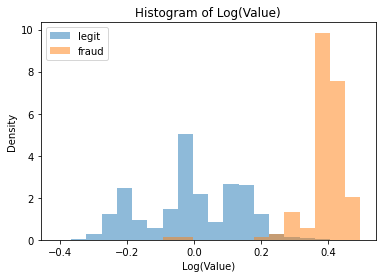

In [77]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,48], bins=20, label='legit', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,48], bins=bins, label='fraud', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='Log(Value)', ylabel='Density', title='Histogram of Log(Value)')

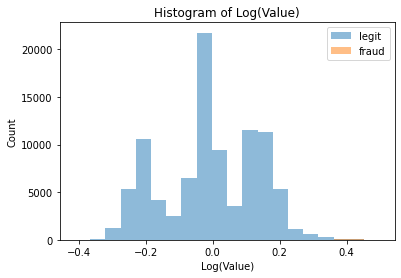

In [78]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,48], bins=20, label='legit', density=False, alpha=0.5)
_ = ax.hist(X[y_txn==1,48], bins=bins, label='fraud', density=False, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='Log(Value)', ylabel='Count', title='Histogram of Log(Value)')

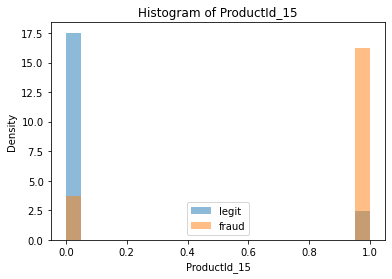

In [79]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,10], bins=20, label='legit', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,10], bins=bins, label='fraud', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='ProductId_15', ylabel='Density', title='Histogram of ProductId_15')

In [80]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_rf = rf.predict_proba(X[val_mask,:])
y_val_rf = rf.predict(X[val_mask,:])
rf

RandomForestClassifier(n_estimators=300)

In [81]:
clf_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
clf_balanced.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lrb = clf_balanced.predict_proba(X[val_mask,:])
y_val_lrb = clf_balanced.predict(X[val_mask,:])

In [82]:
y_hat_test_lr = clf.predict_proba(X[test_mask,:])
y_test_lr = clf.predict(X[test_mask,:])

y_hat_test_lrb = clf_balanced.predict_proba(X[test_mask,:])
y_test_lrb = clf_balanced.predict(X[test_mask,:])

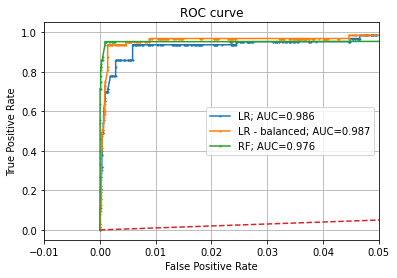

In [83]:
plot_roc(
    [y_txn[val_mask]]*3, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]], 
    ['LR', 'LR - balanced', 'RF'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354617717
Best F1-Score:  0.6567164179104478
LR - balanced
Best threshold:  0.9586202964709065
Best F1-Score:  0.7283950617283951
RF
Best threshold:  0.3336647056647058
Best F1-Score:  0.8666666666666667


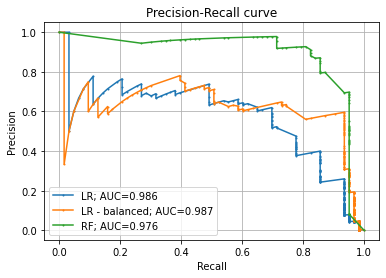

In [84]:
plot_pr(
    [y_txn[val_mask]]*3, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]], 
    ['LR', 'LR - balanced', 'RF'],
)

### Add graph features
As a simple test, we will calculate the amount of fraud in the 2-hop neighborhood, and include this as a feature in our LR model.  Note:  this will present a form of information leak since we'll use the label of the target node itself to calculate the local fraud rate.

In [85]:
X_fr = fraud_rate_2hop.numpy()[:N_labels]
X_fr = (X_fr - X_fr.mean(axis=0))/(X_fr.max(axis=0) - X_fr.min(axis=0))
assert X_fr.shape[0] == N_labels

In [86]:
X_fr_full = np.zeros(X.shape[0])
X_fr_full[:N_labels] = X_fr
X.shape, X_fr_full.shape

((140681, 49), (140681,))

In [87]:
X_mod = np.hstack([X, X_fr_full.reshape((-1, 1))])
X.shape, X_mod.shape

((140681, 49), (140681, 50))

In [88]:
clf_fr = LogisticRegression()
clf_fr.fit(X_mod[train_mask,:], y_txn[train_mask])

y_hat_val_lr_fr = clf_fr.predict_proba(X_mod[val_mask,:])
y_val_lr_fr = clf_fr.predict(X_mod[val_mask,:])

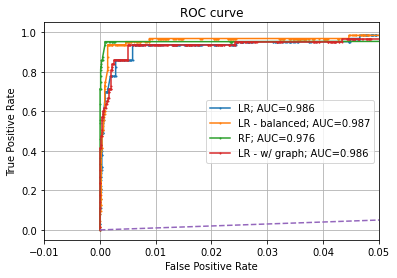

In [89]:
plot_roc(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354617717
Best F1-Score:  0.6567164179104478
LR - balanced
Best threshold:  0.9586202964709065
Best F1-Score:  0.7283950617283951
RF
Best threshold:  0.3336647056647058
Best F1-Score:  0.8666666666666667
LR - w/ graph
Best threshold:  0.2735230183165243
Best F1-Score:  0.6545454545454545


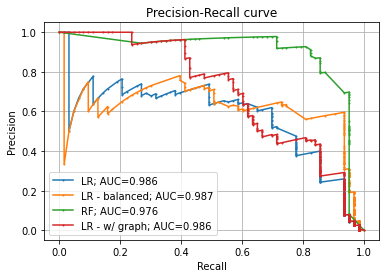

In [90]:
plot_pr(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],
)

### Label Propagation

In [91]:
from scipy.sparse import diags

In [92]:
def label_propagation(g, baseline, train_mask, alpha=0.8, iters=20, warmup=10, dgl=False):
    labels = g.ndata['label']
    txn_idx = g.ndata['_TYPE']==g.ndata['_TYPE'].max().item() # the transaction nodes
    train_mask_g = th.zeros_like(labels).bool()
    train_mask_g[th.where(txn_idx)[0][train_mask]] = 1
    
    # Create (N_nodes, 2) label matrix, first col=legit prob, second col=fraud prob
    ## Init everything to baseline fraud rate
    s = th.zeros((labels.shape[0], 2))
    s[:,0] = 1 - baseline
    s[:,1] = baseline
    
    # overwrite training nodes
    s[(labels==0)&(train_mask_g),0] = 1
    s[(labels==0)&(train_mask_g),1] = 0
    
    s[(labels==1)&(train_mask_g),0] = 0
    s[(labels==1)&(train_mask_g),1] = 1
    
    
    assert (s.sum(dim=1)==1).float().mean()==1
    
    y_train = s.clone().detach()
    y_preds = list()
    
    
    if dgl:
        print('dgl')
        with g.local_scope():
            src, dst = g.edges()
            src_d = g.in_degrees(src).float()
            dst_d = g.in_degrees(dst).float()
            g.edata['w'] = 1/th.sqrt(dst_d) * 1/th.sqrt(src_d) # edge weight w = 1/sqrt(d_i*d_j)
            # Get node-level normalization of edge weights
            g.update_all(fn.copy_e('w', 'm'), fn.sum('m', 'w_total'))
            g.apply_edges(fn.e_div_v('w', 'w_total', 'w_norm')) # w_norm = w/sum(w)

            for e in range(iters):
                g.ndata['feat'] = s 
                g.update_all(
                    fn.u_mul_e('feat', 'w_norm', 'm'), 
                    fn.sum('m', 'h')
                )
                h = g.ndata['h']

                s = alpha*h + (1-alpha)*y_train

                if e >= warmup:
                    y_preds.append(s[th.where(txn_idx)[0]])
    
    
    else:
        print("no dgl")
        adj = g.adj(transpose=True, scipy_fmt='coo')
        d_inv_root = diags(np.sqrt(1/adj.sum(axis=1)).flatten().tolist()[0])
        a_scaled = d_inv_root @ adj @ d_inv_root
        norm = diags((1/a_scaled.sum(axis=1)).flatten().tolist()[0])
        w = (norm @ a_scaled).tocoo()
        w = th.sparse_coo_tensor(np.stack([w.row, w.col]), w.data).float()
        
        for e in range(iters):
            h = (w @ s)
            s = alpha*h + (1-alpha)*y_train
  
            if e >= warmup:
                y_preds.append(s[th.where(txn_idx)[0]])
        
    return y_preds
   

In [93]:
g = dgl.to_homogeneous(hg, ndata=['label'])

In [94]:
# Make sure the indexing aligns
txnTypeIdx = g.ndata['_TYPE'].max().item()
assert th.equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx],
    th.tensor(np.nan_to_num(y_txn, nan=baseline)).float(),
)

assert np.array_equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx][train_mask].numpy(), 
    y_txn[train_mask]
)

In [95]:
y_lps = label_propagation(g, baseline, train_mask, alpha=0.5, iters=20, warmup=10, dgl=True)

dgl


In [96]:
y_test_lp = y_lps[-1][test_mask,:]

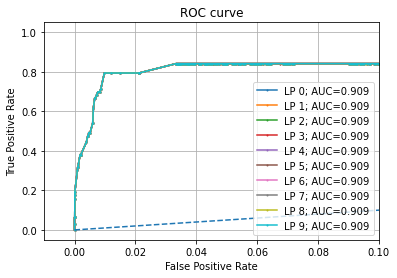

In [97]:
# DGL
plot_roc(
    [y_txn[val_mask]]*len(y_lps), 
    [y[val_mask,1] for y in y_lps], 
    [f'LP {i}' for i in range(len(y_lps))],
    x_max=0.1,
)

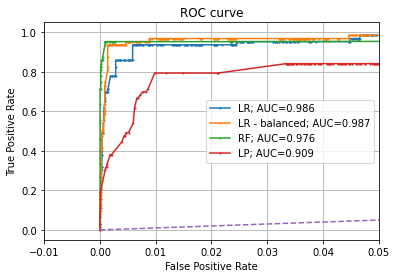

In [98]:
plot_roc(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354617717
Best F1-Score:  0.6567164179104478
LR - balanced
Best threshold:  0.9586202964709065
Best F1-Score:  0.7283950617283951
RF
Best threshold:  0.3336647056647058
Best F1-Score:  0.8666666666666667
LP
Best threshold:  0.037686184
Best F1-Score:  0.35398230088495575


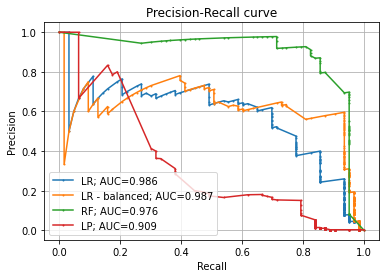

In [99]:
plot_pr(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP'],
)

### GNNs

In [100]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis

In [101]:
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print("loading from disk")
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(best_model_fp))
    else:
        model = model_cp
        
    model.to(device)
    
    model.eval()
    
    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    # dataloader = NodeDataLoader(
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)
    
    y_preds = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))
        
    return th.cat(y_preds).cpu()
    
@th.no_grad()
def test(model, hg, mask, best_path=None):

    model.eval()
    
    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    # dataloader = NodeDataLoader(
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    labels = hg.ndata['label']['txnIdx'].long()
    

    correct = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['txnIdx']]==y_preds).sum().item()
        correct.append((labels[output_nodes['txnIdx']]==y_preds).sum().item())


    acc = sum(correct)/(th.where(mask)[0].shape[0])

    return acc

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    """
    A single training step
    """
    model.train()
    optimizer.zero_grad()

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    # dataloader = NodeDataLoader(
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(train_mask)[0]}, sampler,
        batch_size=1024, shuffle=True, drop_last=False, num_workers=0)
    
    # val_loader = NodeDataLoader(
    val_loader = DataLoader(
        hg, {'txnIdx': th.where(val_mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)
    
    train_losses = list()
    if weight:
        weight = th.tensor([1., 1/baseline]).float().to(device)
    else:
        weight = None
        
    labels = hg.ndata['label']['txnIdx'].long()
    
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['txnIdx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())
    

    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]
            
            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['txnIdx']])
            val_losses.append(val_loss.item())

    return np.array(train_losses).mean(), np.array(val_losses).mean()

def train(hg, split_idx, model, epochs, evaluator, 
          device, save_path, loss_fn=F.cross_entropy, lr=0.01, 
          es_criteria=5, weight_class=False, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()

    features = hg.ndata['feat']
  
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0
    
    for e in range(1, epochs+1):
        
        # print("Training step")
        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        # print("Train eval")
        train_acc = test(model, hg, train_mask)
        # print("Val eval")
        val_acc = test(model, hg, val_mask)
        
        val_metric = val_loss
        
        if val_metric > 1e5:
            print(f"Early stopping for huge loss: {val_metric}")
            break

        # Save the best validation accuracy and the corresponding test accuracy.
        if val_metric < best_val_metric  :
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1
            

        if e % 5 == 0 and verbose:
#             for name, param in model.named_parameters():
#                 print(name, param.grad.max(), param.grad.min())
            
            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_metric, best_val_metric))
            
        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break
            
    return np.array(train_losses), np.array(val_losses)

In [102]:
class RelGraphConvLayer(nn.Module):
    # from https://github.com/dmlc/dgl/blob/master/examples/pytorch/rgcn-hetero/model.py
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 *,
                 num_bases=None,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 bn=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn

        self.conv = HeteroGraphConv({
                rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
            
        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.bn:
                h = self.bn_layer(h)
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [103]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases, 
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout
        
        # GNN layers
        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))
        
        # Output linear layer
        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['txnIdx']
        h = self.output_layer(th.cat([h['txnIdx'], h_in], dim=1))
        return h

    
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [104]:
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        X_tmp = th.tensor(X).float() # the natural features
    else:
        # random values as features
#         X_rand = th.zeros((hg.num_nodes(ntype), X.shape[1]-1))
        X_rand = th.rand((hg.num_nodes(ntype), X.shape[1]-1))-0.5

        print(ntype, hg.num_nodes(ntype))
        in_degrees = th.zeros(hg.num_nodes(ntype))
        for cetype in hg.canonical_etypes:
            if ntype==cetype[2]:
                print(cetype)
                in_degrees += hg.in_degrees(etype=cetype)
        in_degrees = th.log(in_degrees).reshape((-1, 1))
        in_degrees -= in_degrees.mean()

        X_tmp = th.hstack([X_rand, in_degrees])
    hg.nodes[ntype].data['feat'] = X_tmp

acctIdx 4841
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
subIdx 4836
('acctIdx', 'acctIdx-subIdx', 'subIdx')
('txnIdx', 'txnIdx-subIdx', 'subIdx')


In [105]:
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

In [106]:
loss_fn = LabelSmoothing(smoothing=0.1)

In [107]:
model_kwargs = dict(
    in_feats=X.shape[1], h_feats=256, num_classes=2, 
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (acctIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subI

In [108]:
train_losses, val_losses = train(
    hg.to(device), split_mask, model.to(device), 500, None, 
    device, 'gdrive/MyDrive/zindi_dataset/models/rgcn.pt', loss_fn=loss_fn, lr=0.001, 
    es_criteria=50, verbose=True, weight_class=True,
)

In epoch 5, loss: 0.220, val metric: 0.215 (best 0.215)
In epoch 10, loss: 0.218, val metric: 0.225 (best 0.211)
In epoch 15, loss: 0.210, val metric: 0.212 (best 0.209)
In epoch 20, loss: 0.211, val metric: 0.208 (best 0.208)
In epoch 25, loss: 0.207, val metric: 0.208 (best 0.206)
In epoch 30, loss: 0.205, val metric: 0.206 (best 0.206)
In epoch 35, loss: 0.203, val metric: 0.204 (best 0.204)
In epoch 40, loss: 0.203, val metric: 0.204 (best 0.204)
In epoch 45, loss: 0.204, val metric: 0.206 (best 0.204)
In epoch 50, loss: 0.203, val metric: 0.206 (best 0.204)
In epoch 55, loss: 0.203, val metric: 0.206 (best 0.204)
In epoch 60, loss: 0.204, val metric: 0.206 (best 0.204)
In epoch 65, loss: 0.204, val metric: 0.206 (best 0.204)
In epoch 70, loss: 0.203, val metric: 0.204 (best 0.204)
In epoch 75, loss: 0.203, val metric: 0.204 (best 0.204)
In epoch 80, loss: 0.204, val metric: 0.204 (best 0.204)
In epoch 85, loss: 0.203, val metric: 0.205 (best 0.204)
In epoch 90, loss: 0.203, val me

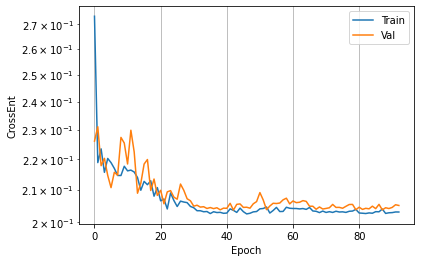

In [111]:
plot_losses(train_losses, val_losses, log=True)

In [113]:
y_val_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['valid'].to(device), 'gdrive/MyDrive/zindi_dataset/models/rgcn.pt')

loading from disk


LR
Best threshold:  0.11474674354617717
Best F1-Score:  0.6567164179104478
LR - balanced
Best threshold:  0.9586202964709065
Best F1-Score:  0.7283950617283951
RF
Best threshold:  0.3336647056647058
Best F1-Score:  0.8666666666666667
LP
Best threshold:  0.037686184
Best F1-Score:  0.35398230088495575
RGCN
Best threshold:  0.42138278
Best F1-Score:  0.4424778761061947


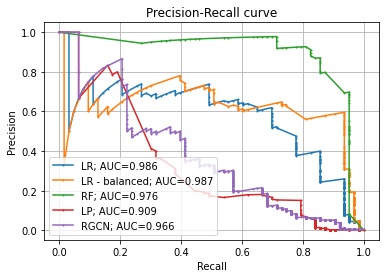

In [114]:
plot_pr(
    [y_txn[val_mask]]*5, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1], y_val_hat_rgcn[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP', 'RGCN'],
)

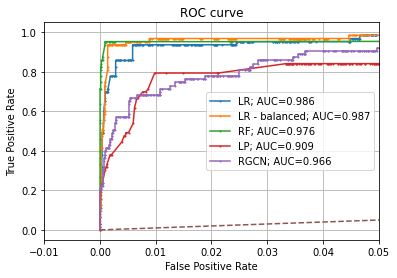

In [115]:
plot_roc(
    [y_txn[val_mask]]*5, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1], y_val_hat_rgcn[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP', 'RGCN'],
    x_max=0.05,
)

In [ ]:
y_test_hat_rgcn = infer(
    model.to(device), hg.to(device), split_mask['test'].to(device), 'gdrive/MyDrive/zindi_dataset/models/rgcn.pt'
)